# Waveform Shape

Neural oscillations vary in their waveform shape, which can impact their measurements and interpretations.

### Issue

Neural oscillations are often non-sinusoidal, and exhibit variability in their waveform shape. 

This can cause issues with analysis methods that assume sinusoidal bases. 

This includes confounded power measurements (due to harmonics), spurious phase-amplitude coupling (PAC), and biased filter outputs.

### Solution

Waveform shape can and should be explicitly checked and measured.

### Related Work

Core citations / links:
- [When brain rhythms aren't ‘rhythmic’: implication for their mechanisms and meaning](https://doi.org/10.1016/j.conb.2016.06.010), Jones, 2016
- [Brain Oscillations and the Importance of Waveform Shape](https://doi.org/10.1016/j.tics.2016.12.008), Cole & Voytek, 2017

### Related Discussion / Examples

This example uses the [ByCycle](https://bycycle-tools.github.io/) module for measuring cycle-by-cycle variation.

- Tutorials on the ByCycle approach are available [here](https://bycycle-tools.github.io/bycycle/auto_tutorials/index.html)
- A relevant example on the interaction of shape and PAC is [here](https://bycycle-tools.github.io/bycycle/auto_examples/plot_3_pac_feature_distributions.html)

In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt

from fooof.plts.spectra import plot_spectra, plot_spectrum_shading
from fooof.utils import trim_spectrum

from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times, set_random_seed
from neurodsp.sim import sim_oscillation, sim_combined, sim_powerlaw

In [39]:
# Import bycycle module, which is used for this example
import bycycle.features
from bycycle.features import compute_features

In [3]:
# Add path and import custom code for the project
import sys
sys.path.append('code')
from utils import mu_wave, compute_pac
from plts import (plot_waveform, plot_power_by_shape, plot_harmonic_power, 
                  plot_pac, plot_legend, savefig)
from settings import ALPHA_COLOR, ALPHA_RANGE

## Settings

In [4]:
import seaborn as sns
sns.set_context('poster')

In [5]:
# Set random seed
set_random_seed(808)

In [6]:
# Set the average function to use
avg_func = np.nanmean

In [7]:
# Define general simulation settings
n_seconds = 25
fs = 1000

times = create_times(n_seconds, fs)

In [8]:
# Define parameters for the simulations
exp = -1.5
ap_filt = (2, 150)
cf = 10
rdsym = 0.05

In [9]:
# Define ranges of interest
psd_range = (2, 50)
beta_range = (15, 35)

In [10]:
# Define range of values to use for oscillation asymmetry
rdsyms = [0.50, 0.625, 0.75, 0.875]

In [11]:
# Collect parameters and set up simulations
comps = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
         'sim_oscillation' : {'freq' : cf, 'cycle' : 'asine', 'rdsym' : rdsym}}

# Define relative power of the signal components
comp_vars = [1, 0.8]

In [12]:
# Plot settings
plt_kwargs = {'xlabel' : '', 'ylabel' : '', 'alpha' : [0.75, 0.75]}

# Define plot colors
cmap = [plt.cm.viridis(i) for i in np.linspace(0, 1, len(rdsyms) + 1)]
cmap = cmap[::-1]

mu_color = "k"
sinus_color = "r"
harmonic_color = "b"
colors = [mu_color, sinus_color, harmonic_color]

In [13]:
# Burst detection settings for ByCycle
burst_detection_kwargs = {
    "amplitude_fraction_threshold": 0.0,
    "amplitude_consistency_threshold": 0.0,
    "period_consistency_threshold": 0.0,
    "monotonicity_threshold": 0.0}

In [14]:
# Set whether to save out figures
SAVE_FIG = False

## Simulate Time Series

First, let's visualize an asymmetric oscillation. 

In [15]:
# Simulate an asymmetric oscillation
osc = sim_oscillation(n_seconds, fs, cf, cycle='asine', rdsym=rdsym)

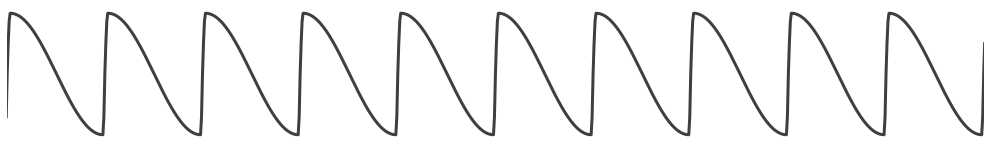

In [16]:
# Visualize the asymmetric oscillation
plot_time_series(times, osc, xlim=[5, 6], **plt_kwargs)
plt.axis('off');
savefig(SAVE_FIG, '05-shape_osc')

In [17]:
# Simulate the combined time series
ap = sim_powerlaw(n_seconds, fs, exponent=exp, f_range=ap_filt, variance=0.1)

# Create the combiend signal
sig = osc + ap

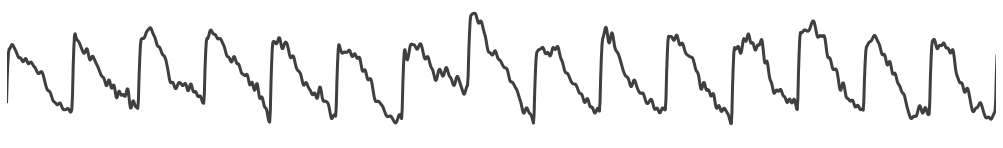

In [18]:
# Plot the simulated time series
plot_time_series(times, sig, xlim=[5, 6.5], **plt_kwargs)
plt.axis('off')
savefig(SAVE_FIG, '05-ts_comb')

### Filter Time Series

Next, let's explore filtering our simulated signal. 

With the filtering we want to pay particular attention to how narrowband filters distort the shape of asymmetric oscillations.

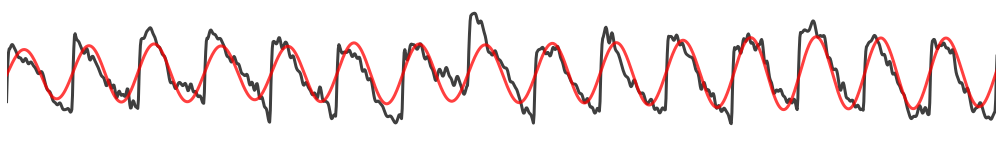

In [19]:
# Filter the signal, including a broadband filter, and the alpha range
sig_filt_al = filter_signal(sig, fs, 'bandpass', ALPHA_RANGE)

# Plot the alpha filtered signal, compared to the original signal
plot_time_series(times, [sig, sig_filt_al], xlim=[5, 6.5], **plt_kwargs)
plt.axis('off')
savefig(SAVE_FIG, '05-ts_filt')

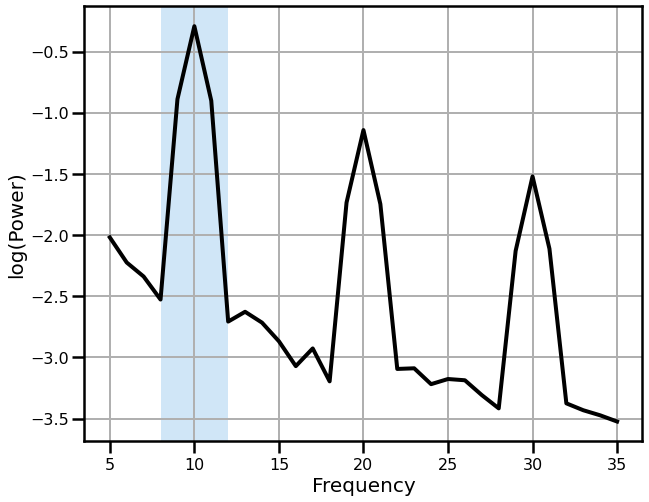

In [20]:
# Compute and plot the power spectrum of the signal
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig, fs, nperseg=fs), (5, 35))
plot_spectrum_shading(freqs1, powers1, ALPHA_RANGE, color='k',
                      log_freqs=False, log_powers=True,
                      lw=4, shade_colors=ALPHA_COLOR)
savefig(SAVE_FIG, '05-psd')

## Simulate Across Waveform Shapes

Words, words, words.

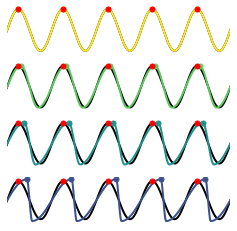

In [21]:
# Simulate and plot asymmetric oscillations across waveforms
fig, ax = plt.subplots(4, 1, figsize=(4, 4))

oscs = []
for ind, rdsym in enumerate(rdsyms):
    
    osc = sim_oscillation(n_seconds, fs, cf, cycle="asine", rdsym=rdsym)
    oscs.append(osc)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)    
        df = compute_features(osc, fs, f_range=(cf - 2, cf + 2),
                              burst_detection_kwargs=burst_detection_kwargs)

        sig_filt_al = filter_signal(osc, fs, "bandpass", ALPHA_RANGE)
        df_filt = compute_features(sig_filt_al, fs, f_range=(cf - 2, cf + 2),
                                   burst_detection_kwargs=burst_detection_kwargs)
    
    plot_waveform(times, osc, sig_filt_al, df, df_filt, color=cmap[ind],
                  xlim=(4.5, 5), ylim=(-1.6, 1.6), ax=ax[ind])
savefig(SAVE_FIG, '05-waveforms')

### Compute Power Spectra

Next, let's compute the power spectrum of the simulated signal. 

In the power spectrum, we will be paying attention to harmonics that arise due to the asymmetric oscillation. 

Note, in the following plot, that are are clear harmonics, that show up in the beta range. 

In [22]:
# Create an aperiodic component to add to signals
ap = sim_powerlaw(n_seconds, fs, exponent=-2.5)

In [23]:
# Compute power spectra for each signal, adding an aperiodic component
all_pows = []
for osc in oscs:
    cur_freqs, cur_pows = compute_spectrum(osc + 20 * ap, fs, nperseg=1.5 * fs)
    all_pows.append(cur_pows)

In [24]:
# Restrict power specra to range of interest
freqs, psd = trim_spectrum(cur_freqs, np.array(all_pows), psd_range)

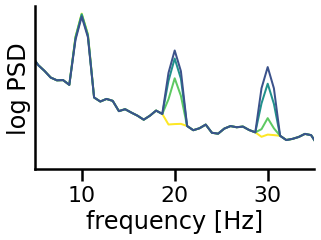

In [25]:
# Plot spectra
_, ax_psd = plt.subplots(figsize=(5, 3))
for ind in range(4):
    ax_psd.semilogy(freqs, psd[ind].T, color=cmap[ind], lw=2)
ax_psd.set(xlabel="frequency [Hz]", xlim=(5, 35), yticks=[], ylabel="log PSD")
sns.despine(ax=ax_psd)

### Compare across asymmetry values

Next, let's extend the analysis, and simulate signals across different oscillation asymmetries. 

In [37]:
# Settings for current simulations
n_trials = 50
rdsyms_all = np.arange(0.5, 1, 0.025)
beta_pows = np.zeros((len(rdsyms_all), n_trials))

In [27]:
# simulate for a number of trials
for i_rdsym, cur_rdsym in enumerate(rdsyms_all):
    for i_trial in range(n_trials):

        # Create the signal
        comps = {"sim_powerlaw": {"exponent": exp, "f_range": ap_filt},
                 "sim_oscillation": {"freq": cf, "cycle": "asine", "rdsym": cur_rdsym}}
        cur_sig = sim_combined(n_seconds, fs, comps, comp_vars)

        # Compute the spectrum and collect the measured beta power
        cur_freqs, cur_pows = compute_spectrum(cur_sig, fs, nperseg=fs)
        _, beta_pow = trim_spectrum(cur_freqs, cur_pows, beta_range)
        beta_pow = np.mean(beta_pow)
        beta_pows[i_rdsym, i_trial] = beta_pow

mean_beta = np.mean(beta_pows, axis=1)
std_beta = np.std(beta_pows, axis=1)

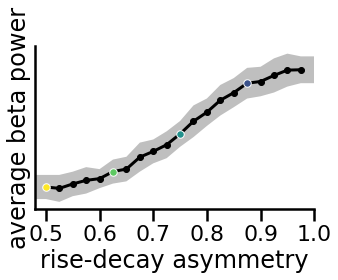

In [28]:
# Plot the measured beta power across waveform shape
plot_power_by_shape(rdsyms_all, mean_beta, std_beta, rdsyms, cmap)

In the above, we can see that the the measured beta power tracks the waveform shape of the simulated oscillation. 

Keep in mind this is relating measured _beta_ power to the shape of an _alpha_ oscillation. 

In this simulation, there is no actual beta power. This shows spurious power, due to the harmonics. 

### Compute Phase-Amplitude Coupling

Finally, let's examine phase-amplitude coupling.

Phase-amplitude coupling is an analysis to investigate coupling between multiple, distinct oscillations. 

Note that in our example signal, there is only one oscillation, and so there can be no true coupling between multiple periodic components. Despite this, non-sinusoidal rhythms can induce artifactual phase-amplitude coupling. 

In [29]:
# Define time vector for these simulations
time = np.arange(0, 2, 0.001)

# Simulate signals
signal_alpha, signal_beta = mu_wave(time, 0, cf, comb=False)
signal_mu = signal_alpha + signal_beta

In [30]:
# Filter signals to ranges of interest
signal_mu_filt = filter_signal(signal_mu, fs, "bandpass", [15, 25], remove_edges=False)
signal_beta_filt = filter_signal(signal_beta, fs, "bandpass", [17.5, 22.5], n_cycles=3, remove_edges=False)
signal_alpha_filt = filter_signal(signal_alpha, fs, "bandpass", [15, 25],remove_edges=False)

/Users/tom/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/checks.py:172: UserWarning: Transition bandwidth is  5.5  Hz. This is greater than the desiredpass/stop bandwidth of  5.0 Hz
  warn('Transition bandwidth is  {:.1f}  Hz. This is greater than the desired'\


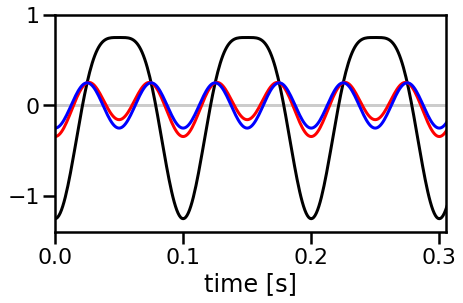

In [38]:
# Plot the time series and filtered traces
plot_harmonic_power(time, signal_mu, signal_mu_filt, signal_beta, colors)

In [32]:
# Compute power spectra for different signal components
freqs, spec_mu = compute_spectrum(signal_mu, fs, f_range=psd_range)
freqs, spec_beta = compute_spectrum(signal_beta, fs, f_range=psd_range)
freqs, spec_beta_filt = compute_spectrum(signal_beta_filt, fs, f_range=psd_range)
freqs, spectrum_alpha = compute_spectrum(signal_alpha, fs, f_range=psd_range)

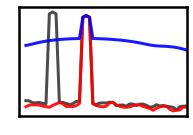

In [33]:
# Plot a spectrum of the different signal components
_, axins = plt.subplots(figsize=(3, 2))
axins.semilogy(freqs, spec_mu, color=mu_color, alpha=0.7)
axins.semilogy(freqs, spec_beta, color=sinus_color, alpha=0.9)
axins.semilogy(freqs, spec_beta_filt, color=harmonic_color, alpha=0.9)
axins.set(xlim=(0, psd_range[1]), xticks=[], yticks=[]);

In [34]:
# Compute phase amplitude coupling
bins, pac = compute_pac(signal_mu_filt, signal_beta_filt, signal_alpha)

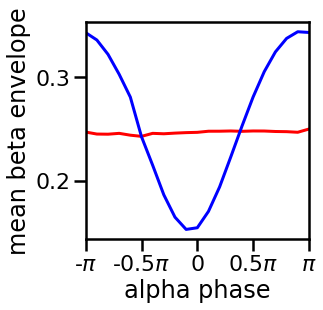

In [35]:
# Plot the calculate phase-amplitude coupling
plot_pac(bins, pac, [sinus_color, harmonic_color])

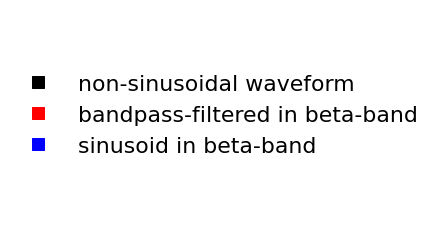

In [36]:
# Create a plot of the legend for the above example
labels = ["non-sinusoidal waveform", "bandpass-filtered in beta-band", "sinusoid in beta-band"]
plot_legend(labels, colors)

### Conclusion

Many of the methods that are commonly used assume and embody assumptions of sinusoidality.

This can be an issue, as the observed oscillations in neural data are often neural data. 

As we've explored here, non-sinusoidal oscillations can induce spurious or biased measures of power, phase-amplitude coupling, and filter outputs. 

These issues can be addressed by explicitly measuring waveform shape, both as a measure of interest itself, and to check whether waveform shape measures may explain any other measured changes. 